## CPOL Hydrometeor classification

In [84]:
import pyart
import numpy as np
from scipy import ndimage, interpolate
from matplotlib import pyplot as plt
%matplotlib inline
from netCDF4 import Dataset

In [3]:
input_file = '/home/rjackson/data/radar/cfrad.20110202_071003.000_to_20110202_071820.000_Gunn_Pt_v8794_UNKNOWN_SUR.nc'

In [4]:
radar = pyart.io.read(input_file)
radar.info()

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	units: meters
	long_name: altitude
	positive: up
	_FillValue: -9999.0
altitude_agl:
	data: <ndarray of type: float64 and shape: (1,)>
	units: meters
	long_name: altitude_above_ground_level
	positive: up
	_FillValue: -9999.0
antenna_transition:
	data: <ndarray of type: int8 and shape: (5400,)>
	units: 
	long_name: antenna_is_in_transition_between_sweeps
	comment: 1 if antenna is in transition, 0 otherwise
	_FillValue: -128
azimuth:
	data: <ndarray of type: float32 and shape: (5400,)>
	units: degrees
	long_name: ray_azimuth_angle
	_FillValue: -9999.0
elevation:
	data: <ndarray of type: float32 and shape: (5400,)>
	units: degrees
	long_name: ray_elevation_angle
	positive: up
	_FillValue: -9999.0
fields:
	PHIDP:
		data: <ndarray of type: float32 and shape: (5400, 592)>
		_FillValue: -32768
		grid_mapping: grid_mapping
		sampling_ratio: 1.0
		coordinates: time range
		units: deg
	ZDR:
		data: <ndarray of type: float32 and shape: (

## Derive pseudo-NCP

In [5]:
print('Calculating texture....')
nyq_Gunn = radar.instrument_parameters['nyquist_velocity']['data'][0]
data = ndimage.filters.generic_filter(radar.fields['Vel']['data'],
                                      pyart.util.interval_std, size = (3,3),
                                      extra_arguments = (-nyq_Gunn, nyq_Gunn))
filtered_data = ndimage.filters.median_filter(data, size = (3,3))
texture_field = pyart.config.get_metadata('corrected_velocity')
texture_field['data'] = filtered_data
texture_field['data'] = filtered_data
radar.add_field('velocity_texture', texture_field, replace_existing = True)

Calculating texture....


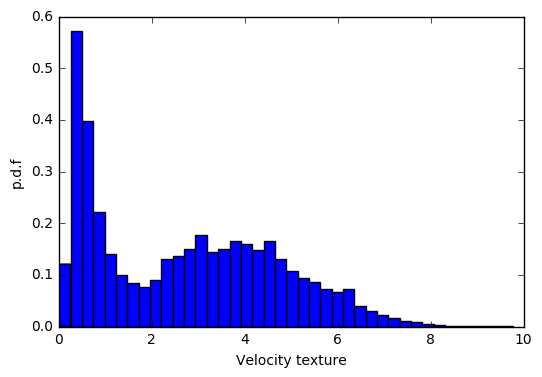

In [6]:
texture = radar.fields['velocity_texture']['data']
plt.hist(texture[texture > 0], normed=1, bins=40)
plt.xlabel('Velocity texture')
plt.ylabel('p.d.f')

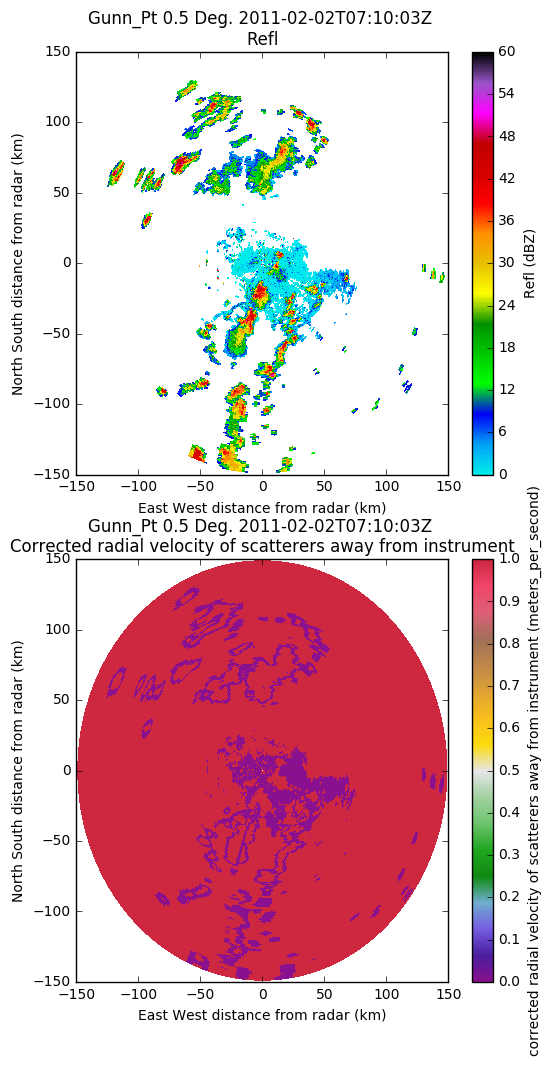

In [126]:
NCP = np.zeros(texture.shape)
NCP[texture < 2] = 1
radar.add_field_like('velocity_texture', 'normalized_coherent_power', NCP, replace_existing = True)
plt.figure(figsize=(6,12))
plt.subplot(212)
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi('normalized_coherent_power', vmin=0, vmax=1)
plt.subplot(211)
display.plot_ppi('Refl', vmin=0, vmax=60, cmap=pyart.graph.cm.NWSRef)

## Derive KDP

In [9]:
reproc_phase, sobe_kdp = pyart.correct.phase_proc_lp(radar,
                                                     offset=0,
                                                     refl_field='Refl',
                                                     phidp_field='PHIDP',
                                                     rhv_field='RHOHV',
                                                     LP_solver='pyglpk')

In [16]:
radar.add_field('specific_differential_phase', reproc_phase, replace_existing = True)
radar.add_field('corrected_differential_phase', sobe_kdp, replace_existing = True)

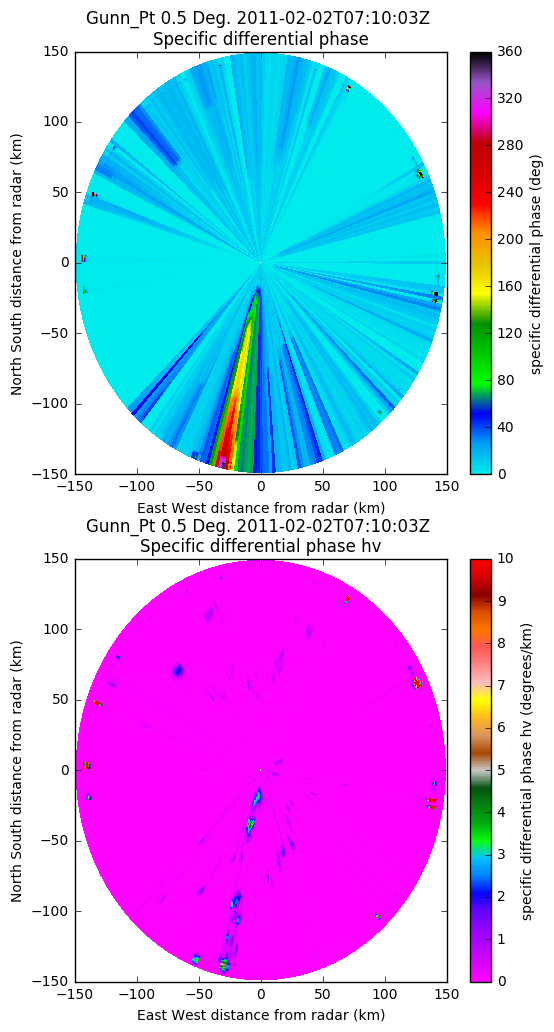

In [22]:
plt.figure(figsize=(6,12))
plt.subplot(212)
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi('corrected_differential_phase', vmin=0, vmax=10)
plt.subplot(211)
display.plot_ppi('specific_differential_phase', vmin=0, vmax=360
                 , cmap=pyart.graph.cm.NWSRef)

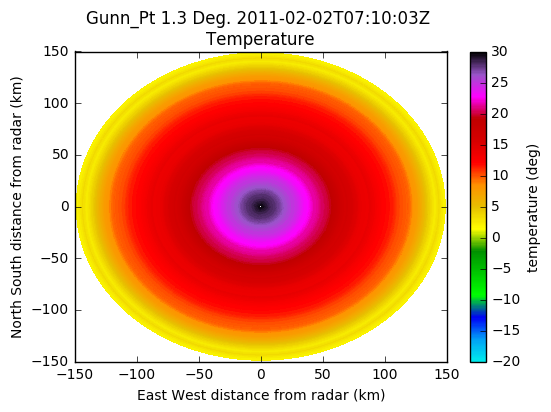

In [110]:
altitudes = radar.gate_altitude['data']

sounding_input_file = '/home/rjackson/data/soundings/twpsondewnpnC3.b1.20111202.111900.custom.cdf'
Sounding_netcdf = Dataset(sounding_input_file, mode='r')

# Convert timestamps to datetime format
Time = Sounding_netcdf.variables['time_offset'][:]
base_time = Sounding_netcdf.variables['base_time'][:]
alt = Sounding_netcdf.variables['alt'][:]
u = Sounding_netcdf.variables['u_wind'][:]
v = Sounding_netcdf.variables['v_wind'][:]
t = Sounding_netcdf.variables['tdry'][:]

function = interpolate.interp1d(alt,t,bounds_error=False)
temp = np.zeros(altitudes.shape)

for j in range(0,592):
    temp[:,j] = function(altitudes[:,j])

radar.add_field_like('specific_differential_phase', 
                     'temperature', temp, replace_existing = True)
display.plot_ppi('temperature', vmin=-20, vmax=30, sweep=2,
                 cmap=pyart.graph.cm.NWSRef)
#plt.plot(alt,t)

In [192]:
hydrometeor_class = pyart.retrieve.hydroclass_semisupervised(radar, 
                                                             refl_field='Refl',
                                                             rhv_field='RHOHV',
                                                             temp_field='temperature',
                                                             zdr_field='ZDR',
                                                             kdp_field='corrected_differential_phase',
                                                             weights=np.array([1.0, 
                                                                               0.75,
                                                                               1.,
                                                                               0.75,
                                                                               0.5]))
radar.add_field('hydrometeor_class', hydrometeor_class, replace_existing=True)

{'units': 'legend', 'long_name': 'Radar Echo classification', 'standard_name': 'radar_echo_classification', 'data': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [3, 3, 0, ..., 0, 0, 0],
       [3, 3, 0, ..., 0, 0, 0],
       [3, 3, 0, ..., 0, 0, 0]]), 'coordinates': 'elevation azimuth range'}
{'units': 'legend', 'long_name': 'Radar Echo classification', 'standard_name': 'radar_echo_classification', 'data': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [3, 3, 0, ..., 0, 0, 0],
       [3, 3, 0, ..., 0, 0, 0],
       [3, 3, 0, ..., 0, 0, 0]]), 'coordinates': 'elevation azimuth range'}


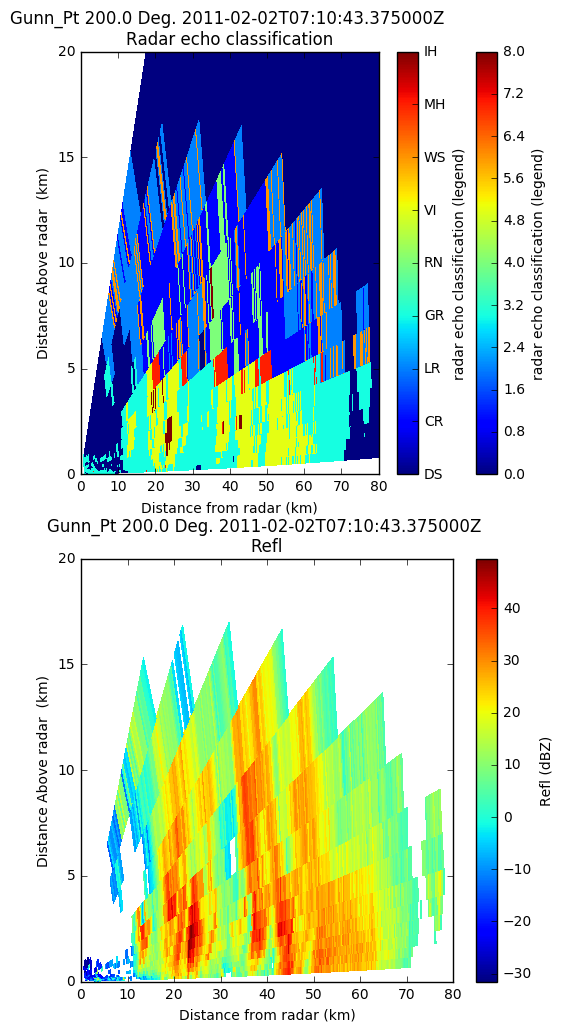

In [196]:
radar_xsection = pyart.util.cross_section_ppi(radar, [200])

display_xsection = pyart.graph.RadarMapDisplay(radar_xsection)
plt.figure(figsize=(6,12))
plt.subplot(211)
display_xsection.plot_rhi('hydrometeor_class',
                          vmin=0,
                          vmax=8)
plt.ylim([0,20])
plt.xlim([0,80])
print(hydrometeor_class)
display_xsection.plot_colorbar(ticks=[0,1,2,3,4,5,6,7,8],
                               ticklabs=['DS','CR', 
                                         'LR','GR',
                                         'RN','VI',
                                         'WS','MH',
                                         'IH'])

plt.subplot(212)
display_xsection.plot_rhi('Refl')
plt.ylim([0,20])
plt.xlim([0,80])
print(hydrometeor_class)
